In [536]:
import sys,os
import numpy as np
import pandas as pd
import random
import math
from time import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../unpast_paper/')

from unpast.run_unpast import unpast
from unpast.utils.io import read_bic_table
from unpast.utils.method import zscore, prepare_input_matrix

import matplotlib.pyplot as plt

from unpast.utils.figs import draw_heatmap2

%matplotlib inline

In [537]:
def do_NMF(X,n_components=4,plot= True,seed=0):
    from sklearn.decomposition import NMF
    model = NMF(n_components=n_components,
                #init='kmeans',
                #tol=10e-6,
                max_iter=1000,
                random_state=seed)
    W = model.fit_transform(X)
    H = model.components_
    W = pd.DataFrame(data=W, index=X.index )
    W.rename(int,axis="columns",inplace=True)
    H = pd.DataFrame(data=H, columns=X.columns )
    
    samples = find_cluster(H.T).sort_values()
    genes = find_cluster(W).sort_values()
    e = X.loc[genes.index,samples.index]
    e_z = zscore(e)
    
    row_colors,col_colors = None,None
    if plot:
        color_dict = dict(zip(sorted(set(samples.values)),sns.hls_palette(n_components, l=0.5, s=0.8)))
        col_colors = samples.map(color_dict)
        #color_dict = dict(zip(sorted(set(genes.values)),sns.hls_palette(n_components, l=0.5, s=0.8)))
        row_colors = genes.map(color_dict)
        #col_colors = samples.map(color_dict)
        #row_colors = genes.map(color_dict)
        fig = sns.clustermap(e_z,
                       col_cluster=False,row_cluster=False,
                       cmap=sns.color_palette("coolwarm", as_cmap=True),
                       vmin=-2,vmax=2,
                       xticklabels=False, yticklabels=False,
                       col_colors=col_colors,
                       row_colors=row_colors,figsize=(5,4))
        fig.cax.set_visible(False)
    return genes, samples, (row_colors, col_colors)


def find_cluster(df):
    # clusters are in columns
    culsters = {}
    for row in df.iterrows():
        culsters[row[0]] = row[1][row[1]==row[1].max()].index[0]
    return pd.Series(culsters)


In [538]:
n_samples = 25
n_features = 50
exprs =  np.zeros((n_samples,n_features)) # generate random expressions from st.normal

np.random.seed(seed=42)

for i in range(n_samples):
    exprs[i,] = np.random.normal(size=n_features,scale  = 1)
    
exprs = pd.DataFrame(data=exprs.T)

s1 = [0,5,8,9,13,19,22,17,21,24]
g1 = [1,7,21,39,41,47]
s2 = [0,1,3,6,7,10,11,13,12,17,21,24]
g2 = [3,9,15,42]
s3 = [0,1,2,4,7,10,12,18,19,20,21]
g3u = [10,25,30]
g3d = [45]
g3 = g3u+g3d

exprs.loc[g1,s1] += np.random.normal(size=exprs.loc[g1,s1].shape,loc=5, scale  = 1)
exprs.loc[g2,s2] += np.random.normal(size=exprs.loc[g2,s2].shape,loc=-5, scale  = 1)

exprs.loc[g3u,s3] += np.random.normal(size=exprs.loc[g3u,s3].shape,loc=5, scale  = 1)
exprs.loc[g3d,s3] += np.random.normal(size=exprs.loc[g3d,s3].shape,loc=-5, scale  = 1)

# add differential co-expression pattern hight with 
g_co = [11,16,17,18,22,23,24,31,32,33,37,40,43,44,46]
s_co = [1,2,3,4,5,6,7,8,9,10,11,12,19,22]
x_0 = np.random.normal(size=exprs.loc[g_co[0],s_co].shape,loc=0, scale = 5)
exprs.loc[g_co[0],s_co] = x_0
frac = 0.5
for g in g_co[1:]:
    x_i = x_0 * frac + np.sqrt(1 - frac**2) * exprs.loc[g, s_co]
    exprs.loc[g, s_co] = x_i
    if g%2 == 0:
        exprs.loc[g, s_co] = -x_i
print("\tavg. co-exprs. bic.:",
      (exprs.loc[g_co, s_co].T.corr().applymap(np.abs).sum().sum() - len(g_co))
      / ((len(g_co) ** 2 - len(g_co)) )
     )
s_co_ = sorted(set(exprs.columns).difference(set(s_co)))
print("\tavg. co-exprs. bg.:",
      (exprs.loc[g_co, s_co_].T.corr().applymap(np.abs).sum().sum() - len(g_co))
      / ((len(g_co) ** 2 - len(g_co)) )
     )



bics = pd.DataFrame.from_dict({"B0":{"genes":set(g1),"genes_up":set(g1),"genes_down":set([]),
                                    "samples":set(s1),
                                    "n_genes":len(g1),
                                    "n_samples":len(s1)},
                               "B1":{"genes":set(g2),"genes_up":set([]),"genes_down":set(g2),
                                    "samples":set(s2),
                                    "n_genes":len(g2),
                                    "n_samples":len(s2)},
                               "B2":{"genes":set(g3),"genes_up":set(g3u),"genes_down":set(g3d),
                                    "samples":set(s3),
                                    "n_genes":len(g3),
                                    "n_samples":len(s3)},
                               "B3":{"genes":set(g_co),"genes_up":set(g_co),"genes_down":set([]),
                                    "samples":set(s_co),
                                    "n_genes":len(g_co),
                                    "n_samples":len(s_co)}
                               
                              }).T
bics

	avg. co-exprs. bic.: 0.9019234177739417
	avg. co-exprs. bg.: 0.23910685183729322


,genes,genes_up,genes_down,samples,n_genes,n_samples
B0,"{1, 39, 7, 41, 47, 21}","{1, 39, 7, 41, 47, 21}",{},"{0, 5, 8, 9, 13, 17, 19, 21, 22, 24}",6,10
B1,"{9, 42, 3, 15}",{},"{9, 42, 3, 15}","{0, 1, 3, 6, 7, 10, 11, 12, 13, 17, 21, 24}",4,12
B2,"{25, 10, 45, 30}","{25, 10, 30}",{45},"{0, 1, 2, 4, 7, 10, 12, 18, 19, 20, 21}",4,11
B3,"{32, 33, 37, 40, 11, 43, 44, 46, 16, 17, 18, 2...","{32, 33, 37, 40, 11, 43, 44, 46, 16, 17, 18, 2...",{},"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 19, 22}",15,14


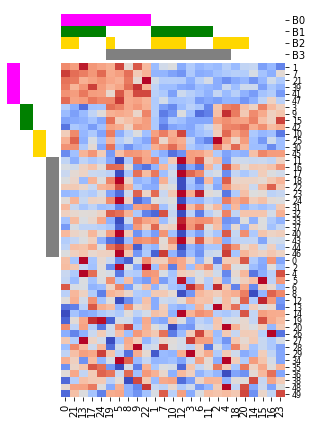

In [539]:
exprs_z = prepare_input_matrix(exprs,ceiling=3)
exprs_z.index = [int(x) for x in exprs_z.index]
exprs_z.columns = [int(x) for x in exprs_z.columns]
g,colors_order,(row_colors, col_colors) = draw_heatmap2(exprs_z,
                                                     bics,
                                                     bicluster_colors =  ["magenta","green","gold","grey"],
                                  figsize=(4.5,6),
                                  cluster_rows=False,
                                  dendrogram_ratio=(0.01,0.01),
                                  colors_ratio=(0.03/4.5*7, 0.03),
                                  col_labels = True,
                                  row_labels = True,
                                  color_range=(-2,2),
                                  legend_n_cols=0,
                                  bic_prefix = "",
                                  xlabel="",
                                  no_cbar= True,
                                  plot_bg_genes=True,
                                  no_row_colors=False)

tmp = g.ax_row_colors.set_xticks([])
ax = g.ax_heatmap
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontsize=8)
for ext in ["png","pdf","svg"]:
    pass#plt.savefig("../img/Fig1_v9/input_sorted."+ext,dpi=300)

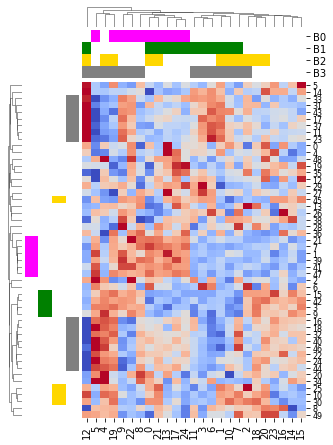

In [541]:
row_order = sorted(exprs_z.index) #bic_row_order #sorted(exprs.index)       
col_order = sorted(exprs_z.columns) #bic_col_order# sorted(exprs.columns)    


data_reordered = exprs_z.loc[row_order, col_order]

g = sns.clustermap(
    data_reordered,
    cmap="coolwarm", vmin = -2, vmax= 2,
    figsize=(4.5*1.05,6*1.05),
    colors_ratio=(0.03/4.5*7, 0.03),
    dendrogram_ratio=(0.05,0.05),
    cbar_pos = None,
    #row_cluster=False,  
    #col_cluster=False,
    row_colors=row_colors,
    col_colors=col_colors

)

data_reordered = g.data2d

tmp = g.ax_heatmap.set_xticks(np.arange(len(data_reordered.columns))+0.5)
tmp = g.ax_heatmap.set_xticklabels(data_reordered.columns)
tmp = g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)

tmp = g.ax_heatmap.set_yticks(np.arange(len(data_reordered.index))+0.5)
tmp = g.ax_heatmap.set_yticklabels(data_reordered.index)
tmp = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)

tmp = g.ax_row_colors.set_xticks([])
ax = g.ax_heatmap
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontsize=8)
for ext in ["png","pdf","svg"]:
    pass#plt.savefig("../img/Fig1_v9/output_HC_clust."+ext,dpi=300)

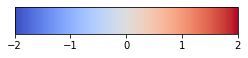

In [542]:
# --- Extract the mappable from the heatmap ---
mappable = g.ax_heatmap.collections[0]

# --- Create a new figure for horizontal colorbar ---
fig, ax = plt.subplots(figsize=(4.0, 0.5))  # wide and short
fig.colorbar(mappable, cax=ax, orientation="horizontal")

for ext in ["svg"]:
    pass#plt.savefig("../img/Fig1_v9/color_legend."+ext,dpi=300)

Read input from  Fig1_v3/exprs_v9.tsv
	50 features x 25 samples
Mininal number of samples in a bicluster: 5
The size of empirical SNR distribution: 10000
	Input is not standardized.
	Centering mean to 0
	Scaling std to 1
	Standardized expressions will be limited to [-3,3]:

Binarization started ....

		genes processed: 0
	Binarization for 50 features completed in 0.12 s
	Generate background distribuition of SNR depending on the bicluster size ...
		total samples: 25,
		number of samples in a bicluster: 5 - 12,
		n_permutations: 10000
		snr pval threshold: 0.01
	Background ditribution generated in 0.15 s
		UP-regulated features:	8
		DOWN-regulated features:	5


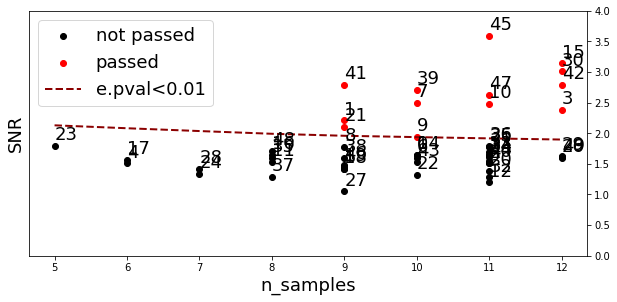

Clustering features ...

		WGCNA pre-clustering: True
	Running WGCNA for Fig1_v3/exprs_v9.kmeans.pval=0.01.seed=42.BOTH.tmpWGCNA_25.09.09_17:02:54.tsv ...
	R command line:
	Rscript /home/olya/TUM/DESMOND/DESMOND2/unpast_paper/unpast/utils/run_WGCNA.R Fig1_v3/exprs_v9.kmeans.pval=0.01.seed=42.BOTH.tmpWGCNA_25.09.09_17:02:54.tsv 3 0.995 signed_hybrid 10 T
	WGCNA runtime: modules detected in 15.21 s.
	modules: 3, not clustered features 0 
Fig1_v3/exprs_v9.seed=42.bin=kmeans,pval=0.01,clust=WGCNA,direction=BOTH,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv
Total runtime: 16.18 s


b'Warning messages:\n1: replacing previous import \xe2\x80\x98ellipsis::check_dots_unnamed\xe2\x80\x99 by \xe2\x80\x98rlang::check_dots_unnamed\xe2\x80\x99 when loading \xe2\x80\x98tibble\xe2\x80\x99 \n2: replacing previous import \xe2\x80\x98ellipsis::check_dots_used\xe2\x80\x99 by \xe2\x80\x98rlang::check_dots_used\xe2\x80\x99 when loading \xe2\x80\x98tibble\xe2\x80\x99 \n3: replacing previous import \xe2\x80\x98ellipsis::check_dots_empty\xe2\x80\x99 by \xe2\x80\x98rlang::check_dots_empty\xe2\x80\x99 when loading \xe2\x80\x98tibble\xe2\x80\x99 \n4: replacing previous import \xe2\x80\x98ellipsis::check_dots_unnamed\xe2\x80\x99 by \xe2\x80\x98rlang::check_dots_unnamed\xe2\x80\x99 when loading \xe2\x80\x98pillar\xe2\x80\x99 \n5: replacing previous import \xe2\x80\x98ellipsis::check_dots_used\xe2\x80\x99 by \xe2\x80\x98rlang::check_dots_used\xe2\x80\x99 when loading \xe2\x80\x98pillar\xe2\x80\x99 \n6: replacing previous import \xe2\x80\x98ellipsis::check_dots_empty\xe2\x80\x99 by \xe2\x8

,SNR,n_genes,n_samples,genes,samples,direction,genes_up,genes_down,gene_indexes,sample_indexes
0,6.587669,6,10,"{21, 41, 1, 7, 39, 47}","{9, 8, 17, 0, 21, 24, 5, 13, 19, 22}",UP,"{21, 41, 1, 7, 39, 47}",{},"{1, 39, 7, 41, 47, 21}","{0, 5, 8, 9, 13, 17, 19, 21, 22, 24}"
1,5.276533,3,11,"{10, 45, 30}","{12, 20, 4, 0, 21, 10, 1, 7, 2, 18, 19}",BOTH,"{10, 30}",{45},"{10, 45, 30}","{0, 1, 2, 4, 7, 10, 12, 18, 19, 20, 21}"
2,3.743014,4,12,"{9, 15, 3, 42}","{12, 17, 0, 21, 6, 11, 10, 1, 24, 7, 13, 3}",DOWN,{},"{9, 15, 3, 42}","{9, 42, 3, 15}","{0, 1, 3, 6, 7, 10, 11, 12, 13, 17, 21, 24}"


In [580]:
exprs_file = "Fig1_v3/exprs_v9.tsv"
exprs.to_csv(exprs_file,sep = "\t")

basename = "exprs_v9"
out_dir = "Fig1_v3/"
seed = 42

from unpast.run_unpast import unpast

biclusters_pred = unpast(exprs_file, basename,
                          out_dir=out_dir,
                          save=False, load=False,
                          directions= ["BOTH"],
                          seed = seed,
                          verbose = True,plot_all=True)
biclusters_pred

In [581]:
col_order = sns.color_palette("pastel",n_colors=k).as_hex()
cl_ids = [ x*1.0 for x in range(len(col_order))]
c_dict = dict(zip(cl_ids,col_order)) 


fig_size = (4.5,6)
rl = True
fs = 9

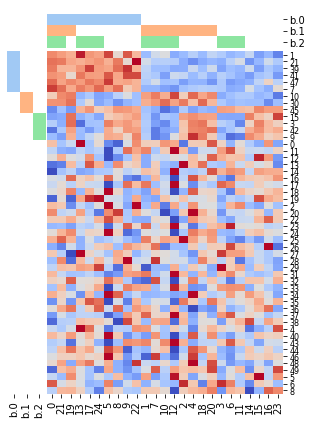

In [582]:
exprs_z = prepare_input_matrix(exprs,ceiling=3)
exprs_z.index = [str(x) for x in exprs_z.index]
exprs_z.columns = [str(x) for x in exprs_z.columns]
row_colors.index = [str(x) for x in row_colors.index]
col_colors.index = [str(x) for x in col_colors.index]


cg,co,(row_colors2, col_colors2) = draw_heatmap2(exprs_z,
                                                       biclusters_pred,
                                  figsize=(4.5,6),
                                  cluster_rows=False,
                                  dendrogram_ratio=(0.01,0.01),
                                  colors_ratio=(0.03/4.5*7, 0.03),
                                  col_labels = True,
                                  row_labels = True,
                                   #bicluster_colors = ["pink","lightgreen","yellow"], #
                                    bicluster_colors = sns.color_palette("pastel",n_colors=biclusters_pred.shape[0]).as_hex(),
                                    plot_bg_genes = True,
                                   color_range=(-2,2),
                                    legend_n_cols=0,
                                    bic_prefix = "b.",xlabel ="", 
                                    no_cbar= True,
                                     no_row_colors = False)



ax = cg.ax_heatmap
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontsize=8, rotation=0)

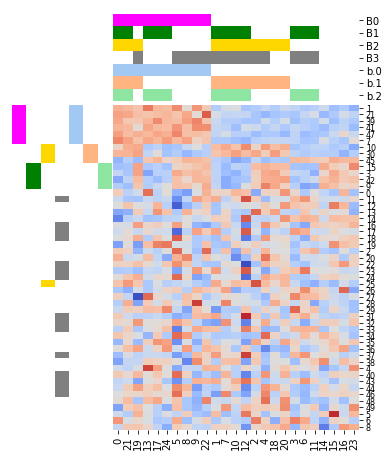

In [583]:
col_colors2 = pd.concat([col_colors.iloc[:,:true_biclusters.shape[0]], col_colors2],axis=1)
row_colors2 =pd.concat([row_colors.iloc[:,:true_biclusters.shape[0]], row_colors2],axis=1)

cg4 = sns.clustermap(exprs_z.loc[cg.data2d.index,cg.data2d.T.index],
                     row_cluster=False,col_cluster=False,
                     figsize=(5.5,6.5),
                     cmap=sns.color_palette("coolwarm", as_cmap=True),vmin=-3,vmax=3,
                     dendrogram_ratio=(0.01,0.01),
                     colors_ratio=(0.03/5.5*7.5, 0.03),
                     col_colors=col_colors2, 
                     row_colors=row_colors2,
                   xticklabels=True, yticklabels=rl)
cg4.ax_cbar.set_visible(False)
cg4.ax_row_colors.set_xticks([])
cg4.ax_row_colors.set_xticklabels(cg4.ax_row_colors.get_xticklabels(), rotation=0)

tmp = cg4.ax_heatmap.set_yticklabels(cg4.ax_heatmap.get_ymajorticklabels(), fontsize = 8)

for ext in ["png","pdf","svg"]:
    plt.savefig("../img/Fig1_v9/output_unpast_BOTH_biclust."+ext,dpi=300)
    #plt.savefig("../img/Fig1_v9/output_unpast_default_biclust."+ext,dpi=300)

# Clustering

In [584]:
k = 5
col_order = sns.color_palette("pastel",n_colors=k).as_hex()
cl_ids = [ x*1.0 for x in range(len(col_order))]
c_dict = dict(zip(cl_ids,col_order)) 
k

5

['#a1c9f4', '#ffb482', '#8de5a1', '#ff9f9b', '#d0bbff']


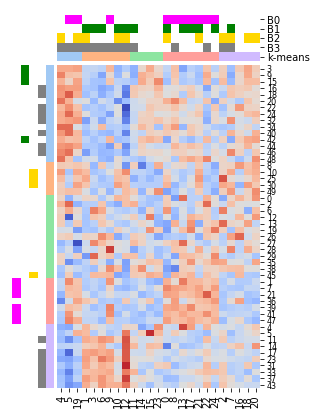

In [585]:
# kmeans 
from sklearn.cluster import KMeans
g_labels = KMeans(n_clusters=k,
                        random_state=42,
                        init="random",
                        n_init=10).fit(exprs_z).labels_
s_labels = KMeans(n_clusters=k,
                        random_state=42,
                        init="random",
                        n_init=10).fit(exprs_z.T).labels_
s_clust = pd.Series(s_labels,index =exprs_z.columns).sort_values()
g_clust = pd.Series(g_labels,index =exprs_z.index).sort_values()

col_colors.loc[s_clust.index,"k-means"] = s_clust.values
col_colors["k-means"] = col_colors["k-means"].apply(lambda x: c_dict[x])

row_colors.loc[g_clust.index,"k-m."] = g_clust.values
row_colors["k-m."] = row_colors["k-m."].apply(lambda x: c_dict[x])

rows_sorted = []
cols_sorted = []
print(col_order)
for c in col_order:
    rows_sorted.append(row_colors.loc[row_colors["k-m."]==c,:])
    cols_sorted.append(col_colors.loc[col_colors["k-means"]==c,:])
rows_sorted = pd.concat(rows_sorted,axis=0).loc[:,list(true_biclusters.index.values)+["k-m."]]
cols_sorted = pd.concat(cols_sorted,axis=0).loc[:,list(true_biclusters.index.values)+["k-means"]]


cg4 = sns.clustermap(exprs_z.loc[rows_sorted.index,cols_sorted.index],
                     row_cluster=False,col_cluster=False,
                     figsize=fig_size,
                     cmap=sns.color_palette("coolwarm", as_cmap=True),vmin=-3,vmax=3,
                     dendrogram_ratio=0.01,
                     colors_ratio=(0.034,0.025),
                     col_colors=cols_sorted, 
                     row_colors=rows_sorted,
                   xticklabels=True, yticklabels=rl)
cg4.ax_cbar.set_visible(False)

cg4.ax_row_colors.set_xticks([])
cg4.ax_row_colors.set_xticklabels(cg4.ax_row_colors.get_xticklabels(), rotation=0)

tmp = cg4.ax_heatmap.set_yticklabels(cg4.ax_heatmap.get_ymajorticklabels(), fontsize = 8)
for ext in ["svg","pdf","png"]:
    tmp = plt.savefig("Fig1_v9/Fig1_kmeans_k=%s_v9."%k+ext, transparent=True, dpi = 300)
plt.show()

### Hierarchical (agglomertive)

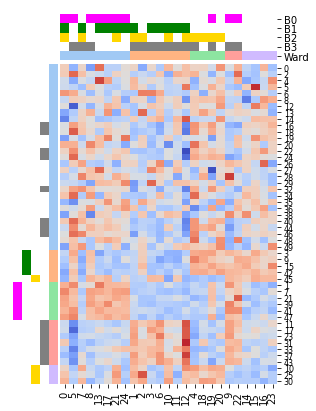

In [586]:
# Clustering - HC 
from sklearn.cluster import AgglomerativeClustering

g_labels = AgglomerativeClustering(n_clusters=k,
                        metric='euclidean',
                        linkage='ward').fit(exprs).labels_
s_labels = AgglomerativeClustering(n_clusters=k,
                        metric='euclidean',
                        linkage='ward').fit(exprs.T).labels_

s_clust = pd.Series(s_labels,index =exprs_z.columns).sort_values()
g_clust = pd.Series(g_labels,index =exprs_z.index).sort_values()

col_colors.loc[s_clust.index,"Ward"] = s_clust.values
col_colors["Ward"] = col_colors["Ward"].apply(lambda x: c_dict[x])

row_colors.loc[g_clust.index,"Ward"] = g_clust.values
row_colors["Ward"] = row_colors["Ward"].apply(lambda x: c_dict[x])

rows_sorted = []
cols_sorted = []
for c in col_order:
    rows_sorted.append(row_colors.loc[row_colors["Ward"]==c,:])
    cols_sorted.append(col_colors.loc[col_colors["Ward"]==c,:])
rows_sorted = pd.concat(rows_sorted,axis=0).loc[:,list(true_biclusters.index.values)+["Ward"]]
cols_sorted = pd.concat(cols_sorted,axis=0).loc[:,list(true_biclusters.index.values)+["Ward"]]

cg4 = sns.clustermap(exprs_z.loc[rows_sorted.index,cols_sorted.index],
                     row_cluster=False,col_cluster=False,
                     figsize=fig_size,
                     cmap=sns.color_palette("coolwarm", as_cmap=True),vmin=-3,vmax=3,
                     dendrogram_ratio=0.01,
                     colors_ratio=(0.034,0.025),
                     col_colors=cols_sorted, 
                     row_colors=rows_sorted,
                   xticklabels=True, yticklabels=rl)
cg4.ax_cbar.set_visible(False)

cg4.ax_row_colors.set_xticks([])

tmp = cg4.ax_heatmap.set_yticklabels(cg4.ax_heatmap.get_ymajorticklabels(), fontsize = 8)
for ext in ["svg","pdf","png"]:
    tmp = plt.savefig("Fig1_v9/Fig1_Ward_k=%s_v9."%k+ext, transparent=True, dpi = 300)
plt.show()

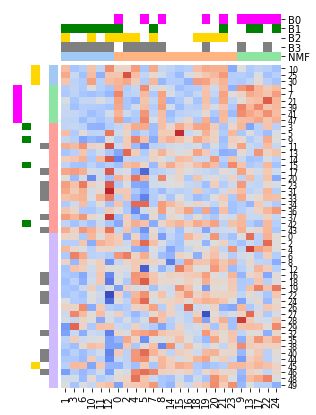

In [587]:
# Factorization - NMF
g_clust, s_clust, (c,r) = do_NMF(exprs_z-exprs_z.min().min(),n_components=k,
                                 plot= False,seed=42)


col_colors.loc[s_clust.index,"NMF"] = s_clust.values
col_colors["NMF"] = col_colors["NMF"].apply(lambda x: c_dict[x])

row_colors.loc[g_clust.index,"NMF"] = g_clust.values
row_colors["NMF"] = row_colors["NMF"].apply(lambda x: c_dict[x])

rows_sorted = []
cols_sorted = []
for c in col_order:
    rows_sorted.append(row_colors.loc[row_colors["NMF"]==c,:])
    cols_sorted.append(col_colors.loc[col_colors["NMF"]==c,:])
rows_sorted = pd.concat(rows_sorted,axis=0).loc[:,list(true_biclusters.index.values)+["NMF"]]
cols_sorted = pd.concat(cols_sorted,axis=0).loc[:,list(true_biclusters.index.values)+["NMF"]]

cg4 = sns.clustermap(exprs_z.loc[rows_sorted.index,cols_sorted.index],
                     row_cluster=False,col_cluster=False,
                     figsize=fig_size,
                     cmap=sns.color_palette("coolwarm", as_cmap=True),vmin=-3,vmax=3,
                     dendrogram_ratio=0.01,
                     colors_ratio=(0.034,0.025),
                     col_colors=cols_sorted, 
                     row_colors=rows_sorted,
                   xticklabels=True, yticklabels=rl)
cg4.ax_cbar.set_visible(False)

cg4.ax_row_colors.set_xticks([])

tmp = cg4.ax_heatmap.set_yticklabels(cg4.ax_heatmap.get_ymajorticklabels(), fontsize = 8)
for ext in ["svg","pdf","png"]:
    tmp = plt.savefig("Fig1_v9/Fig1_NMF_k=%s_v9."%k+ext, transparent=True, dpi = 300)
plt.show()
